In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats
import msprime
import numpy as np


In [2]:
def migration_example(m,d,v,num_replicates=1000,Ne=10**2):
        # M is the overall symmetric migration rate, and d is the number
        # of subpopulations.

        p = v / (m - 1) /2

        # Allocate the initial sample. Because we are interested in the
        # between-subpopulation coalescence times, we choose one sample each
        # from the first two subpopulations.
        population_configurations = [msprime.PopulationConfiguration(sample_size=d) for _ in range(m)]
        # Now we set up the migration matrix. Since this is a symmetric
        # island model, we have the same rate of migration between all
        # pairs of subpopulations. Diagonal elements must be zero.
        migration_matrix = p * np.ones((m,m)) - p * np.eye(m)
        #print(migration_matrix)
        # We pass these values to the simulate function, and ask it
        # to run the required number of replicates.
        replicates = msprime.simulate(Ne=Ne,
            population_configurations=population_configurations,
            migration_matrix=migration_matrix,
            num_replicates=num_replicates,
            mutation_rate=0.00001,length=1)
        # And then iterate over these replicates
        T = np.zeros(num_replicates)
        singular_vals = []
        genoMat = []
        tbls = []
        for i, tree_sequence in enumerate(replicates):

            tree = tree_sequence.first()
            tbl = tree.total_branch_length
            tbls += [tbl]
            genos = np.array(tree_sequence.genotype_matrix(),dtype=float)
            if i % 100 == 0:    
                print(i)
            try:
                genoMat.append(genos[0,:])
            except:
                continue
        genos = np.vstack(genoMat)
        #u,s,v = np.linalg.svd(genos.transpose())
        #print(s.shape)
        #singular_vals.append(s)

        return genos,tbls
        #return singular_vals

0
100
200
300
400
500
600
700
800
900


/Users/ajstern/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in sqrt


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


No handles with labels found to put in legend.


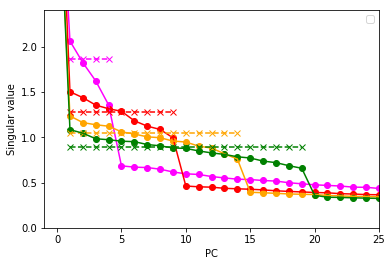

In [64]:
# Using SVD

n = int(20*10)
K = 30
ylim = 0
for (m,v,c) in zip([5,10,15,20],[0.001,0.001,0.001,0.001],['magenta','red','orange','green']):

    d = int(n/m)
    v = 0.005
    #m = 30
    #n = m*d
    N = 5*10**1
    #Z = (2*(1+1/(2*N*v))*np.log(n))**-1

    X,tbls = migration_example(m,d,v,Ne=N)

    

    X = X.transpose()
    
    u,s,V = np.linalg.svd(1/np.sqrt(X.shape[1])*X)
    Z = 4*N/np.mean(tbls)
    

    
    plt.plot(range(0,K),s[:K],color=c)
    plt.scatter(range(0,K),s[:K],color=c,marker='o')

    l1exp = m + (n-d)/(4*N*v)
    l1exp *= Z
    l2exp = m
    l2exp *= Z
    lambda0 = m + n*(m-1)/(n*4*N*v) - (n-d-1)*d*(m-1)/(n*4*N*v)
    plt.plot(range(0,m),[np.sqrt(lambda0)]+[np.sqrt(l1exp) for _ in range(1,m)],color=c,linestyle='dashed',marker='x')
    #plt.plot(range(m,n+1),[np.sqrt(l2exp) for _ in range(n-m+1)],color=c,linestyle='dashed')

    #ylim = np.max([ylim,l1exp*1.5])
plt.axis((0,25,0,2.4))
plt.xlim([-1,25])
#plt.ylim([0,ylim])
#plt.xticks([0]+list(range(9,69,10)),[1]+list(range(10,70,10)))
plt.xlabel('PC')           
plt.ylabel('Singular value')
plt.legend()
#plt.savefig('/Users/ajstern/projects/stratification/eigenvals_m20_v_m40.eps',format='eps')
           
           

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


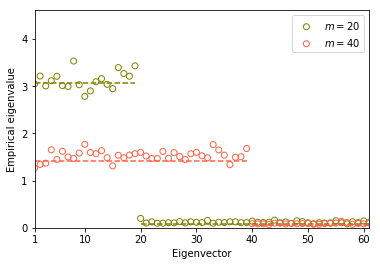

In [3]:
## Using degenerate eigenvectors

n = int(25*40)

ylim = 0
for (m,v,c) in zip([20,40],[0.01,0.01],['olive','tomato','darkmagenta']):

    d = int(n/m)
    v = 0.003
    #m = 30
    #n = m*d
    N = 1*10**2
    #Z = (2*(1+1/(2*N*v))*np.log(n))**-1

    X,tbls = migration_example(m,d,v,Ne=N)

    #for row in range(X.shape[0]):
    #    X[row,:] -= np.mean( X[row,:] )
    #    X[row,:] *= 1/np.std( X[row,:] )
    M = np.cov(X.transpose())

    Z = 4*N/np.mean(tbls)
    #Z = 1

    l1 = []

    ## build eigenvector matrix
    E = []
    for mi in range(m-1):
        e = -d/(n-d) * np.ones(n)
        e[mi*d:mi*d+d] = 1
        E.append(e)
        l1.append(np.linalg.norm(np.dot(M,e),axis=0)/np.linalg.norm(e,axis=0))
    E = np.transpose(np.array(E))
    U,D = np.linalg.qr(E)

    #l1 = np.linalg.norm(np.dot(M,U),axis=0)/np.linalg.norm(U,axis=0)
    #print(l1.shape)

    l2 = []
    for mi in range(m):
        for di in range(d-1):
            e = np.zeros(n)
            e[mi*d:mi*d+d] = -1/(d-1)
            e[mi*d+di] = 1
            l2.append(np.linalg.norm(np.dot(M,e))/np.linalg.norm(e))
    plt.scatter(range(len(l1),len(l1)+len(l2)),np.array(l2),facecolor='none',edgecolor=c,label=r'$m=$'+'%d'%(m))
    plt.scatter(range(len(l1)),np.array(l1),facecolor='none',edgecolor=c)

    l1exp = m + m*(d-1)/(4*N*v)
    l1exp *= Z
    l2exp = m
    l2exp *= Z
    plt.plot(range(0,m-1),[l1exp for _ in range(m-1)],color=c,linestyle='dashed')
    plt.plot(range(m-1,n),[l2exp for _ in range(n-m+1)],color=c,linestyle='dashed')

    ylim = np.max([ylim,l1exp*1.5])
#plt.axis((0,10,0,10))
plt.xlim([0,60])
plt.ylim([0,ylim])
plt.xticks([0]+list(range(9,69,10)),[1]+list(range(10,70,10)))
plt.xlabel('Eigenvector')           
plt.ylabel('Empirical eigenvalue')
plt.legend()
#plt.savefig('/Users/ajstern/projects/stratification/eigenvals_m20_v_m40.eps',format='eps')
           
           

## RUN PCA + GWAS

In [4]:
# imports/defs for multiple linear regression

from sklearn.linear_model import LinearRegression

def sum_squared_error(pred,true):
    return np.sum((pred - true)**2)
def stde(pred, true, coefs, X):
    sse = sum_squared_error(pred,true)/ float(X.shape[0] - X.shape[1])
    standard_error = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
    t_stats = coefs / standard_error
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), X.shape[0] - X.shape[1]))
    return standard_error,p_vals,t_stats

Text(0.5, 1.0, 'n=1000, m=25')

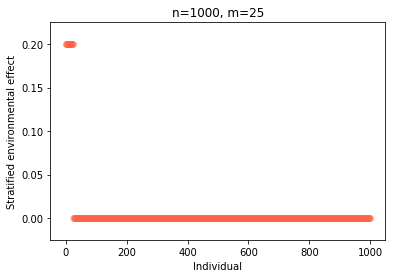

In [5]:
n = 1000
d = 25

def stratified_values(n,d): 
    proj = np.array([1.0/np.sqrt(d) if i < d else 0 for i in range(n)])
    return proj

def var_from_strat(n,d,eta=1):
    Epsi = np.sqrt(d)/n
    Epsi2 = 1/n
    var =  eta**2 * (Epsi2 - Epsi**2)
    return var
    
proj = stratified_values(n,d)
plt.scatter(range(n),proj,c=c,alpha=0.2,marker='o')
plt.ylabel('Stratified environmental effect')
plt.xlabel('Individual')
plt.title('n=%d, m=%d'%(n,d))

0 0.09843245534341277


Text(0, 0.5, '$-\\log_{10}(p)$')

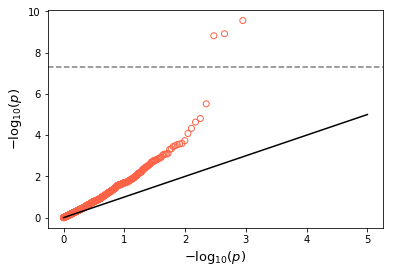

In [7]:
n = 1000
d = 25
K = 20

# proportion of variance due to stratification
pi_s = 0.1

U,s,V = np.linalg.svd(1/np.sqrt(X.shape[0])*X.transpose())
included_covs = U[:,:K]

ps = []
betas = []
ts = []
pLos = []
pHis = []
residuals = []
for _ in range(1):
    Vs = var_from_strat(n,d,eta=1)
    strat_values = stratified_values(n,d)
    pheno_values = strat_values + np.random.normal(0,np.sqrt((1/pi_s - 1)*Vs),size=n)
    print(_,np.var(strat_values)/np.var(pheno_values))
    for i in range(X.shape[0]):

        genotypes = X[i,:]
        designMat = np.zeros((n,K+1))
        designMat[:,0] = genotypes
        designMat[:,1:] = included_covs
        reg = LinearRegression().fit(designMat, pheno_values)
        coefs = reg.coef_
        
        pred = np.dot(designMat,coefs) + reg.intercept_
        
        residuals.append(pred - pheno_values)
        
        sei,pi,ti = stde(pred,pheno_values,coefs,designMat)
        se = sei[0,0]
        betas.append(coefs[0]/se)
        p = pi[0,0]
        t = ti[0,0]
        ps.append(p)
        #ts.append(t)
        #p1 = 2*(1-stats.norm.cdf(np.abs(t)+1.96))
        #p2 = 2*(1-stats.norm.cdf(np.abs(t)-1.96))
        #pLo = np.min([p1,p2]) - p
        #pHi = np.max([p1,p2]) - p
        #pLos.append(pLo)
        #pHis.append(pHi)
    
#plt.hist(ps,bins=np.linspace(0,1,100))    

plt.scatter(-np.log(np.linspace(1,len(ps)-1,len(ps))/len(ps))[::-1]/np.log(10),
         -np.log(np.sort(ps))[::-1]/np.log(10),facecolor='none',edgecolor='tomato')
plt.plot([0,5],[0,5],color='k',)

#P = np.linspace(1,1/len(ps),len(ps))
#plt.fill_between(-np.log(2*(1-stats.norm.cdf(T))),-np.log(Plo),-np.log(Phi),color='gray',alpha=0.5)

plt.axhline(-np.log(5e-8)/np.log(10),color='gray',linestyle='dashed',zorder=-1)
#plt.axis((0,5,0,10))
plt.xlabel(r'$-\log_{10}(p)$',fontsize=13)
plt.ylabel(r'$-\log_{10}(p)$',fontsize=13)


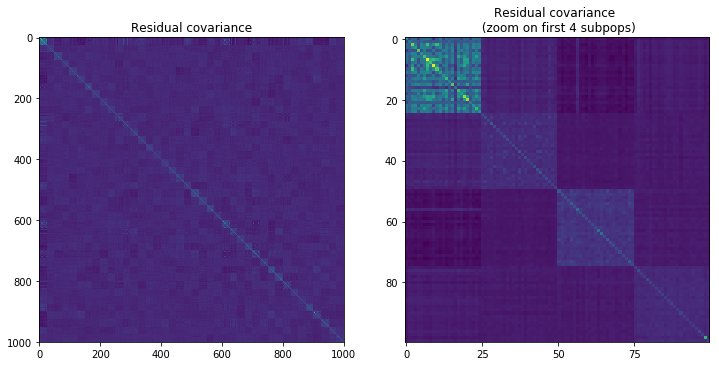

In [20]:
f,ax = plt.subplots(1,2)
f.set_size_inches(12,6)
residuals = np.array(residuals)
SigmaRes = np.cov(residuals.transpose())
ax[0].imshow(SigmaRes)
ax[0].set_title('Residual covariance')
ax[1].set_title('Residual covariance \n (zoom on first 4 subpops)')
ax[1].set_xticks([0,25,50,75,100])

ax[1].imshow(SigmaRes[:100,:100])


In [ ]:
residuals = np.array(residuals)
plt.imshow(np.outer(residuals,residuals),cmap='Spectral')
plt.colorbar()

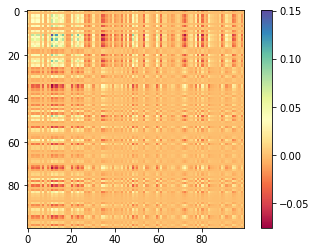

In [101]:
plt.imshow(np.outer(pred-pheno_values,pred-pheno_values)[:100,:100],cmap='Spectral')
plt.colorbar()

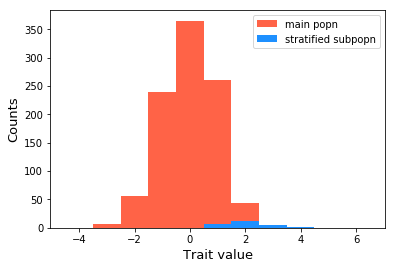

In [79]:
#phenotype distribution

plt.hist(pheno_values[me*d:]/np.std(pheno_values),bins=np.linspace(-4.5,4.5,10),color='tomato',label='main popn')
plt.hist(pheno_values[:me*d]/np.std(pheno_values),bins=np.linspace(-2.5,6.5,10),color='dodgerblue',label='stratified subpopn')
plt.ylabel('Counts',fontsize=13)
plt.xlabel('Trait value',fontsize=13)
plt.legend()
#plt.yscale('log')
#plt.savefig('/Users/ajstern/Documents/stratification/phenos.eps',format='eps')

In [146]:
se,p,t = stde(pred,pheno_values,coefs,designMat)

In [234]:
sProj = np.array([np.dot(e,uj) for uj in u.transpose()])

In [240]:
np.sum(sProj[K:]**2/np.sqrt(n-K))

0.016387527236214155

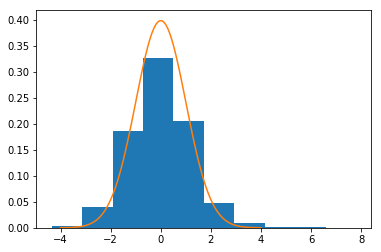

In [454]:
z = np.linspace(-4,4,100)
plt.hist(betas,density=True)
plt.plot(z,stats.norm.pdf(z))

In [44]:
import scipy.stats as stats

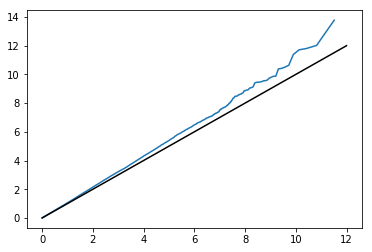

In [66]:
chi2 = np.random.normal(0,1.05,size=10**5)**2
p = -stats.chi2.logsf(np.sort(chi2)[::-1],df=1)
plt.plot(-np.log(np.linspace(1/len(p),1,len(p))),p)
plt.plot([0,12],[0,12],c='k')